EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 08-05-2023
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

- 01-06 SOUID: Source identifier
- 08-15 DATE : Date YYYYMMDD
- 17-21 TG   : mean temperature in 0.1 &#176;C
- 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).
Blended and updated with sources: 111448 127488 128124 
See file sources.txt and stations.txt for more info.

**Import packages**

In [203]:
import pandas as pd
import numpy as np
# timestamp manipulation stack
from dateutil.relativedelta import relativedelta

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# time-related stack
from datetime import datetime as dt

#denoised filter
from scipy.signal import savgol_filter

# statistics stack
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

**load the data**

In [204]:
ts = pd.read_csv('../Time_Series_project/TG_STAID002759.txt',
                    # data starts from line 20
                    skiprows = 19,
                    # remove empty space in column name
                    skipinitialspace = True,
                    # parse DATE column 1
                    parse_dates = [1],
)

**Explore the data**

In [205]:
ts.head()

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0


In [206]:
ts.tail()

,SOUID,DATE,TG,Q_TG
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0
53780,111448,2023-03-31,108,0


**missing values**

In [207]:
#filter dataframe for days are missing value
ts_missing = ts[ts['Q_TG']==9]
ts_missing

,SOUID,DATE,TG,Q_TG
25316,127488,1945-04-25,-9999,9
25317,127488,1945-04-26,-9999,9
25318,127488,1945-04-27,-9999,9
25319,127488,1945-04-28,-9999,9
25320,127488,1945-04-29,-9999,9
...,...,...,...,...
25506,127488,1945-11-01,-9999,9
25507,127488,1945-11-02,-9999,9
25508,127488,1945-11-03,-9999,9
25509,127488,1945-11-04,-9999,9


In [208]:
#first date with missing value
ts_missing['DATE'].min()

Timestamp('1945-04-25 00:00:00')

In [209]:
#last date with missing value
ts_missing['DATE'].max()

Timestamp('1945-11-05 00:00:00')

In [211]:
#days with missing value

missing_days = (ts_missing['DATE'].max() - ts_missing['DATE'].min()).days+1
missing_days

195

In [212]:
#check if all days in between have missing values
missing_days = ts_missing.shape[0]
missing_days

195

comment:missing values over the entire year 1945-04-25 -- 1945-11-05

In [213]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)

In [214]:
# function for clean temperature values
def clean_temp(ts,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperature over the references dates
        temp_value = ts[ts['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10

In [215]:
# create clean temperatutre column
ts['TEMP'] = ts.apply(
    lambda x: clean_temp(ts,x),
    axis=1
)

In [216]:
ts.isnull().count()

SOUID    53781
DATE     53781
TG       53781
Q_TG     53781
TEMP     53781
dtype: int64

**Train-Test split**

In [217]:
ts.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG', 'TEMP'], dtype='object')

In [218]:
#lowercase column name
ts.columns = ts.columns.str.lower()
ts.columns

Index(['souid', 'date', 'tg', 'q_tg', 'temp'], dtype='object')

In [219]:
#extract relevant time series
clean_ts = ts.set_index('date')[['temp']]

In [220]:
clean_ts.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [221]:
#train date from Jan 1876 -  Dec 2022
train = clean_ts[:'2022-12-31']

#test date from Jan  2023 - March 2023
test = clean_ts['2023-01-01':]

In [222]:
train.shape, test.shape

((53691, 1), (90, 1))

In [223]:
#save train data to csv
train.to_csv('train.csv')


#save teat data to csv
test.to_csv('test.csv')

In [224]:
train.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [225]:
test.head()

,temp
date,
2023-01-01,14.5
2023-01-02,13.1
2023-01-03,5.6
2023-01-04,7.1
2023-01-05,8.2


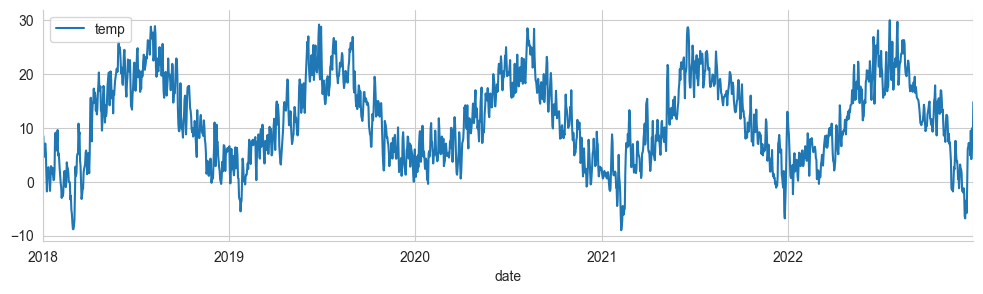

In [226]:
#last 5 years of data with noise 
mpl.rc('figure',figsize=(12,3),dpi=100)

train['temp']['2018-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

**Adding denoised and noised features(columns) to train data**

In [227]:
# savitzky-golary filter will be used to filter the noise
train['denoised'] = savgol_filter(np.array(train['temp']), 99, 3, mode='nearest')
train['noise'] = train['temp'] - train['denoised']

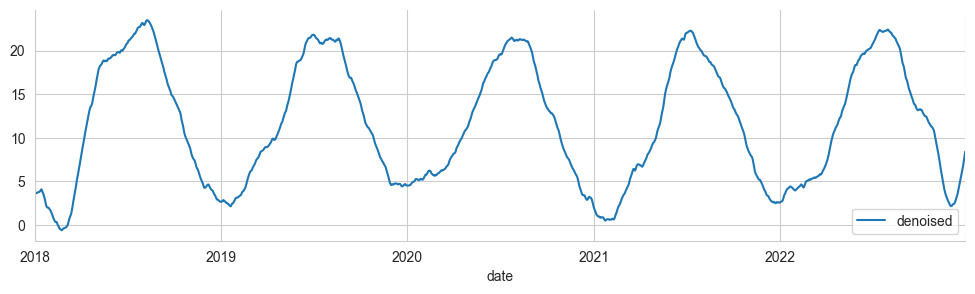

In [228]:
#last 5 years of data with denoised 
mpl.rc('figure',figsize=(12,3),dpi=100)

train['denoised']['2018-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

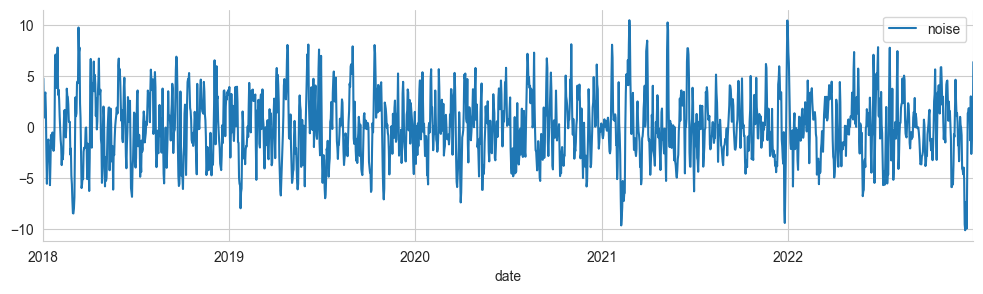

In [229]:
#last 5 years of data with noise
mpl.rc('figure',figsize=(12,3),dpi=100)

train['noise']['2018-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

**Trend on denoised data**

In [230]:
# engineer timestep variable for future convenience

train['timestep'] = list(range(train.shape[0]))

In [231]:
# feature and target for trend model

X_trend = train[['timestep']]
y_trend= train['denoised']
X_trend

,timestep
date,
1876-01-01,0
1876-01-02,1
1876-01-03,2
1876-01-04,3
1876-01-05,4
...,...
2022-12-27,53686
2022-12-28,53687
2022-12-29,53688


**Building a model for denoised**

In [232]:
# trend model

trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [233]:
# fit model

trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

**predict the model**

In [234]:
train['trend'] = trend_model.predict(X_trend)

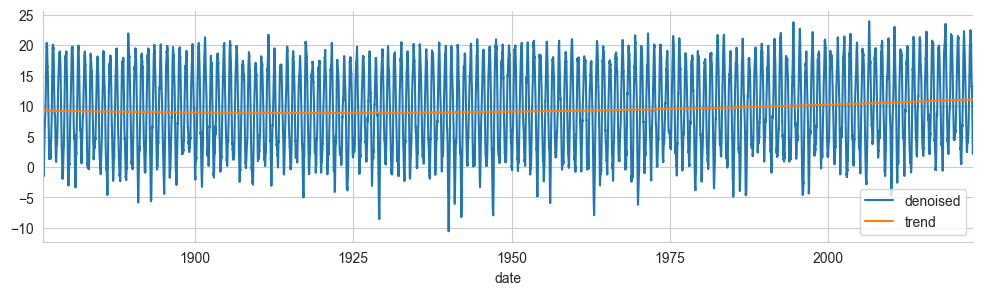

In [235]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['denoised','trend']].plot(legend=True)
sns.despine()

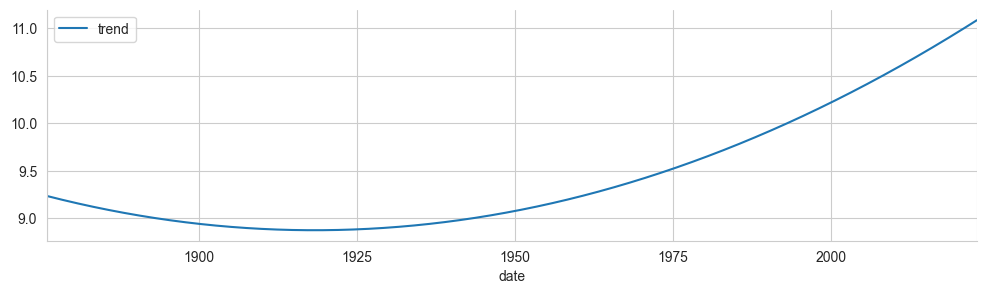

In [236]:
# plotting the trend to see temp variation 
plt.rc('figure',figsize=(12,3),dpi=100)

train[['trend']].plot(legend=True)
sns.despine()

**Seasonality denoised**

In [237]:
train['detrend_and_denoised'] = train['denoised'] - train['trend']
#train['detrend_and_deseasonal_and_denoised'] = train['detrend_and_denoised'] - train['seasonality']

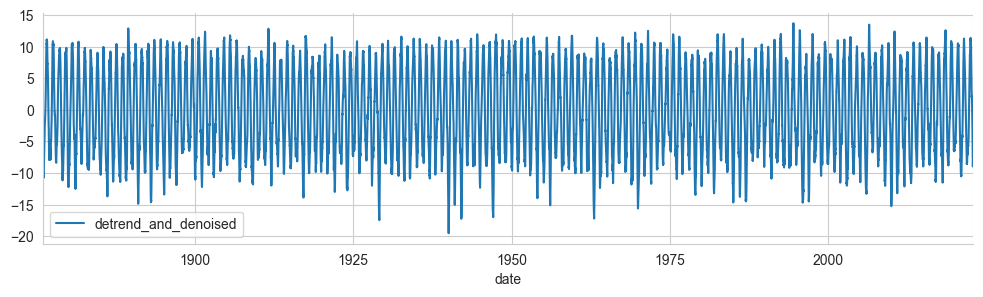

In [238]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrend_and_denoised'].plot(legend=True)
sns.despine()

**feature and target for the seasonality**

In [239]:
train.head()

,temp,denoised,noise,timestep,trend,detrend_and_denoised
date,,,,,,
1876-01-01,2.2,-0.659391,2.859391,0,9.234793,-9.894184
1876-01-02,2.5,-0.772946,3.272946,1,9.234747,-10.007693
1876-01-03,0.3,-0.858296,1.158296,2,9.234700,-10.092996
1876-01-04,-5.8,-1.025494,-4.774506,3,9.234653,-10.260147
1876-01-05,-9.8,-1.151521,-8.648479,4,9.234606,-10.386128


In [240]:
# create day column

#train['day'] = train.index.dayofyear
day = train.index.dayofyear
f = (day-1)/365.24
train['day'] = f
train.tail()

,temp,denoised,noise,timestep,trend,detrend_and_denoised,day
date,,,,,,,
2022-12-27,4.2,6.827954,-2.627954,53686,11.085904,-4.257950,0.985653
2022-12-28,6.3,7.212065,-0.912065,53687,11.086020,-3.873954,0.988391
2022-12-29,10.0,7.611574,2.388426,53688,11.086135,-3.474561,0.991129
2022-12-30,7.6,8.021626,-0.421626,53689,11.086251,-3.064625,0.993867
2022-12-31,14.8,8.411407,6.388593,53690,11.086367,-2.674959,0.996605


In [241]:
# feature and target for seasonality model

X_seasonality = train[['day']]
y_seasonality = train['detrend_and_denoised']

**baseline model for seasonality**

In [242]:
# seasonality model

seasonality_denoised_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [243]:
# fit model

seasonality_denoised_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

**predict the model for seasonality**

In [244]:
train['seasonality'] = seasonality_denoised_model.predict(X_seasonality)

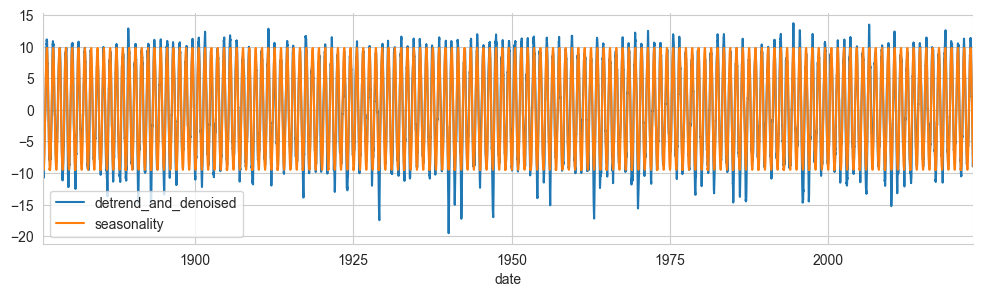

In [245]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrend_and_denoised','seasonality']].plot(legend=True)
sns.despine()

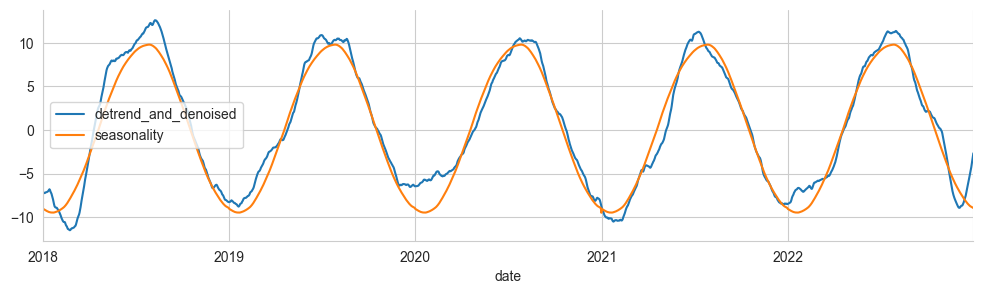

In [246]:
#last 5 years of data with trend and seasonality
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrend_and_denoised','seasonality']]['2018-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

## Baseline model

**Plot trend and seasonality of denosied and original data**

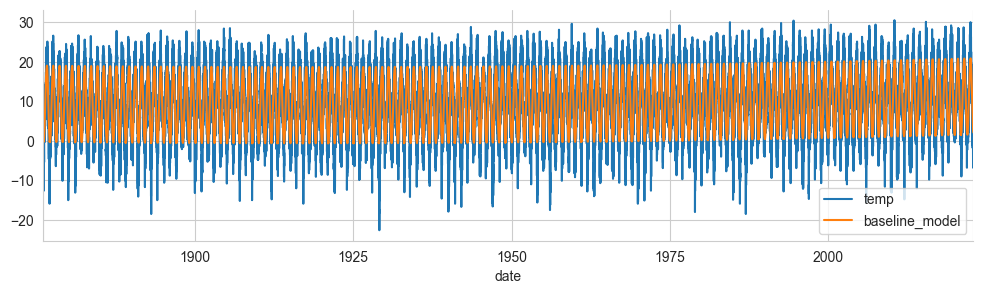

In [247]:
# combine trend and seasonality to create baseline model

train['baseline_model'] = train['trend'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['temp','baseline_model']].plot(legend=True)
sns.despine()

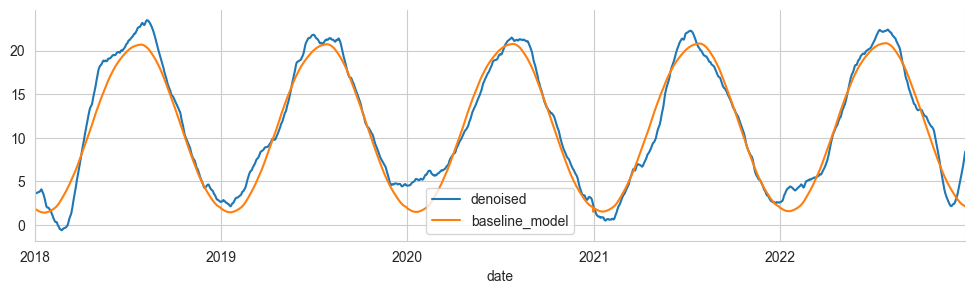

In [248]:
#last 5 years of data of baselinemodel
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['denoised','baseline_model']]['2018-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

**Extract Remainder**

In [250]:
# leftover time series devoid of trend and seasonality

train['remainder'] = train['denoised'] - train['baseline_model']

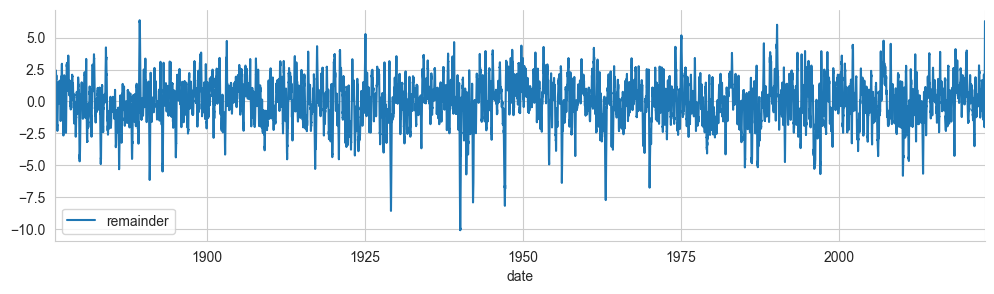

In [251]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

**check homoscedasticity**

In [252]:
def qcd_variance(series,window=12):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [253]:
# quartile coefficient of dispersion

qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.756349


**Save reminder for further analysis**

In [257]:
#tr = train['remainder'].reset_index()
#tr.to_csv('../Time_Series_project/train_remainder.csv',index=False)

**Explore data**

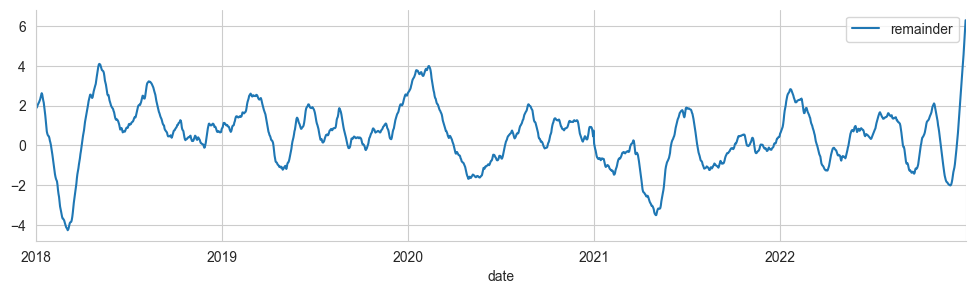

In [254]:
#last 5 years of data for remainder
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder']['2018-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

In [255]:
arma_data = train['remainder']

In [256]:
arma_model = pm.auto_arima(
    arma_data,
    seasonality = False,
    stationarity = False,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-155910.608, Time=44.79 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=211090.848, Time=1.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=15.41 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=138235.240, Time=18.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=211088.848, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-142583.534, Time=31.63 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-155759.746, Time=30.76 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-155027.318, Time=158.40 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-156154.934, Time=38.56 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-147878.158, Time=37.61 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-156272.400, Time=99.43 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-156315.840, Time=38.00 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-155433.955, Time=164.74 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-156324.427, Tim

In [258]:
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(5, 0, 3)   Log Likelihood               78172.499
Date:                Thu, 11 May 2023   AIC                        -156326.998
Time:                        23:43:26   BIC                        -156246.979
Sample:                    01-01-1876   HQIC                       -156302.015
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8416      0.216      8.518      0.000       1.418       2.265
ar.L2         -0.7932      0.453     -1.751      0.080      -1.681       0.095
ar.L3          0.3174      0.338      0.940      0.347      -0.345       0.980
ar.L4         -0.6738      0.296     -2.280      0.023      -1.253      -0.095
ar.L5          0.3064      0.107      2.853      0.004       0.096       0.517
ma.L1         -0.1091      0.216     -0.505      0.614      -0.533       0.314
ma.L2         -0.0927      0.134     -0.693      0.489      -0.355       0.170
ma.L3         -0.4453      0.145     -3.068      0.002      -0.730      -0.161
sigma2         0.0032   8.33e-06    381.819      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           3434870.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -1.68
Prob(H) (two-sided):                  0.05   Kurtosis:                        42.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Modeling the remainder**

In [259]:
# Drop missing values

#tr.dropna(inplace=True)
#tr.head()

,date,remainder
0,1876-01-01,-0.826505
1,1876-01-02,-0.903832
2,1876-01-03,-0.951168
3,1876-01-04,-1.083625
4,1876-01-05,-1.179223


In [262]:
# feature and target for autoregression model

#X_remainder = tr.drop('remainder',axis=1)
#y_remainder = tr[['remainder']]

In [263]:
#X_remainder.shape, y_remainder.shape

((53691, 1), (53691,))

**ARMA model**

In [265]:
# model for remainder

arma_model.fit(train['remainder'])

ARIMA(order=(5, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [279]:
# reminder ARMA model prediction

train['reminder_pred'] = arma_model.predict_in_sample()

**Adding trend, seasonality and reminder predictions which is full denoised data prediction**

In [280]:
train['full_denoised_pred'] = train['reminder_pred'] + train['trend'] + train['seasonality']

**Noised data with ARIMA model**

In [281]:
arima_noise = train['noise']

In [282]:
arima_noise_model = pm.auto_arima(
    arima_noise,
    seasonality = False,
    stationarity = False,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=236170.934, Time=20.79 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=281014.350, Time=2.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237947.817, Time=4.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=248842.149, Time=8.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281012.360, Time=0.68 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=236168.405, Time=7.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=240177.652, Time=10.91 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=236167.313, Time=7.97 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=236168.317, Time=16.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236244.516, Time=4.78 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=236165.314, Time=3.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=248840.154, Time=3.65 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=237945.817, Time=1.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=236166.318, Time=4.83 sec
 A

In [283]:
arima_noise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -118079.657
Date:                Fri, 12 May 2023   AIC                         236165.314
Time:                        00:20:12   BIC                         236191.987
Sample:                    01-01-1876   HQIC                        236173.642
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6375      0.004    159.291      0.000       0.630       0.645
ma.L1          0.2428      0.005     47.709      0.000       0.233       0.253
sigma2         4.7616      0.026    185.205      0.000       4.711       4.812
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1036.54
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.07
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [284]:
# model for remainder

arima_noise_model.fit(train['noise'])

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [285]:
train['noise_predict'] = arima_noise_model.predict_in_sample()
train['noise_predict']

date
1876-01-01    0.000000
1876-01-02    2.124101
1876-01-03    2.356588
1876-01-04    0.448041
1876-01-05   -4.311954
                ...   
2022-12-27    2.959906
2022-12-28   -3.032289
2022-12-29   -0.066639
2022-12-30    2.118865
2022-12-31   -0.885694
Name: noise_predict, Length: 53691, dtype: float64

**Full train data predictions = pred(denoised + noised)**
 1. deniosed  = trend + seasonality + reminder
 2. noised

In [286]:
train['full_data'] = train['full_denoised_pred'] + train['noise_predict']
train.head()

,temp,denoised,noise,timestep,trend,detrend_and_denoised,day,seasonality,baseline_model,remainder,full_denoised_pred,noise_predict,full_data,reminder_pred
date,,,,,,,,,,,,,,
1876-01-01,2.2,-0.659391,2.859391,0,9.234793,-9.894184,0.000000,-9.067679,0.167114,-0.826505,0.167114,0.000000,0.167114,0.000000
1876-01-02,2.5,-0.772946,3.272946,1,9.234747,-10.007693,0.002738,-9.103861,0.130886,-0.903832,-0.694310,2.124101,1.429791,-0.825196
1876-01-03,0.3,-0.858296,1.158296,2,9.234700,-10.092996,0.005476,-9.141828,0.092872,-0.951168,-0.871090,2.356588,1.485498,-0.963962
1876-01-04,-5.8,-1.025494,-4.774506,3,9.234653,-10.260147,0.008214,-9.176523,0.058131,-1.083625,-0.931493,0.448041,-0.483452,-0.989624
1876-01-05,-9.8,-1.151521,-8.648479,4,9.234606,-10.386128,0.010952,-9.206905,0.027701,-1.179223,-1.156706,-4.311954,-5.468660,-1.184407


### TEST DATA
(Jan 2023 - Mar 2023)

**Baseline Forecasts**

In [287]:
#adding timestamp column
test['timestep'] = list(range(train.shape[0], train.shape[0] + test.shape[0]))

In [288]:
# create day column

#test['day'] = train.index.dayofyear
day = test.index.dayofyear
f = (day-1)/365.24
test['day'] = f
test.tail()

,temp,timestep,day
date,,,
2023-03-27,3.4,53776,0.232724
2023-03-28,3.5,53777,0.235462
2023-03-29,6.6,53778,0.238200
2023-03-30,11.7,53779,0.240937
2023-03-31,10.8,53780,0.243675


In [289]:
# savitzky-golary filter will be used to filter the noise
test['denoised'] = savgol_filter(np.array(test['temp']), 99, 3, mode='nearest')
test['nois'] = test['temp'] - test['denoised']

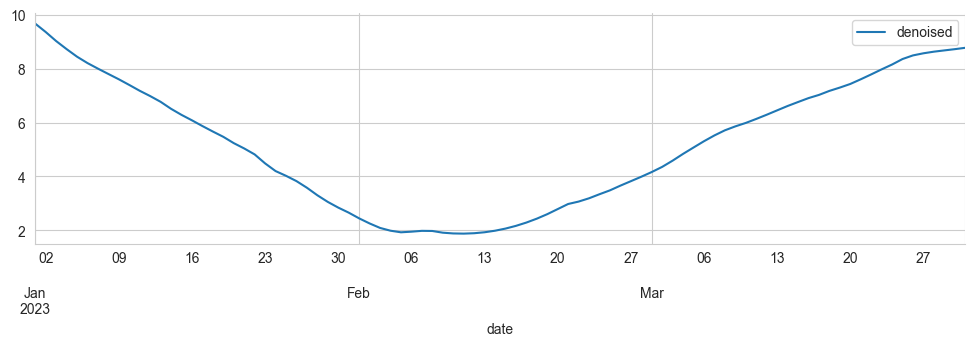

In [290]:
#test data with denoised 
mpl.rc('figure',figsize=(12,3),dpi=100)

test['denoised'].plot(legend=True)
sns.despine()

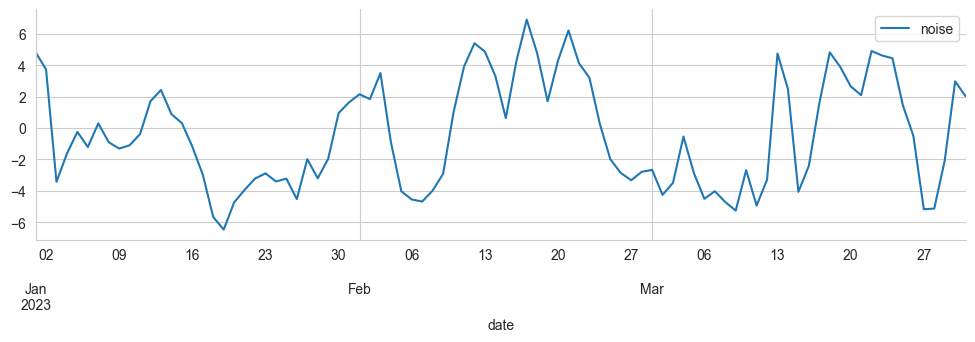

In [291]:
#test data with noise
mpl.rc('figure',figsize=(12,3),dpi=100)

test['noise'].plot(legend=True)
sns.despine()

In [292]:
# feature and target for trend test model

X_trend_test = test[['timestep']]
y_trend_test= test['denoised']

In [293]:
# trend model

trend_test_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [297]:
#predict
test['trend'] = trend_test_model.predict(X_trend_test)

**Seasonality on test**

In [298]:
#detrended test
test['detrend_and_denoised'] = test['denoised'] - test['trend']

In [299]:
# feature and target for seasonality model

X_seasonality_test = test[['day']]
y_seasonality_test = test['detrend_and_denoised']

In [300]:
# seasonality model

seasonality_test_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [319]:
#predict seasonality test model
test['seasonality'] = seasonality_test_model.predict(X_seasonality_test)

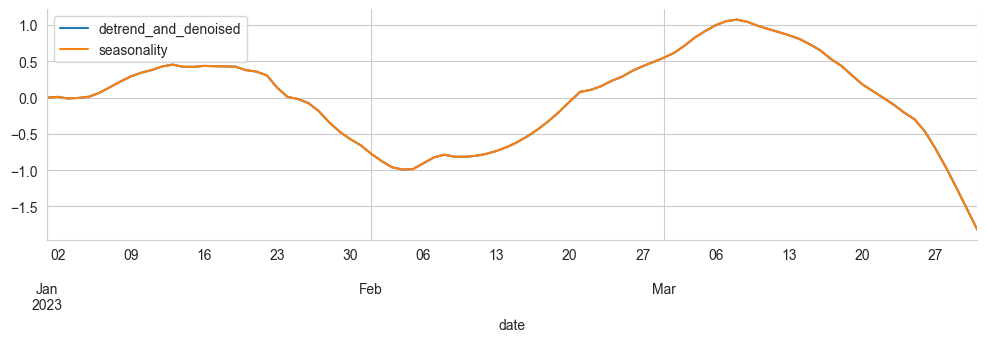

In [303]:
mpl.rc('figure',figsize=(12,3),dpi=100)

test[['detrend_and_denoised','seasonality']].plot(legend=True)
sns.despine()

**baseline model = trend + seasonality**

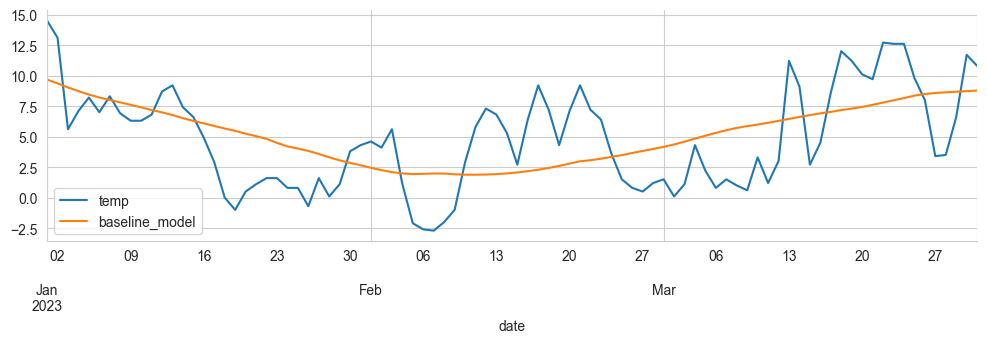

In [305]:
test['baseline_model'] = test['trend'] + test['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
test[['temp','baseline_model']].plot(legend=True)
sns.despine()

**Reminder Test**

In [306]:
# leftover time series devoid of trend and seasonality

test['remainder'] = test['denoised'] - test['baseline_model']

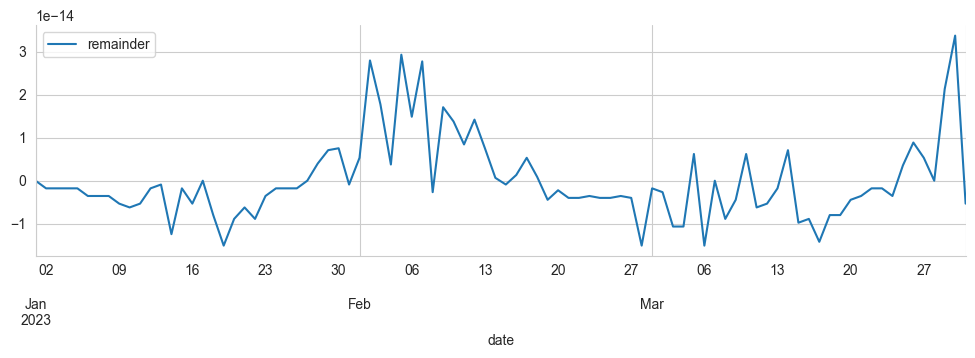

In [314]:
mpl.rc('figure',figsize=(12,3),dpi=100)

test['remainder'].plot(legend=True)
sns.despine()

In [315]:
arima_test_model = test['remainder']

In [316]:
arima_model = pm.auto_arima(
    arima_test_model,
    seasonality = False,
    stationarity = False,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1896.432, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1910.833, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1901.835, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2001.336, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1904.918, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1897.283, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-1987.621, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1896.777, Time=0.96 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1902.248, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 2.596 seconds


In [318]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1003.668
Date:                Fri, 12 May 2023   AIC                          -2001.336
Time:                        00:56:13   BIC                          -1993.837
Sample:                    01-01-2023   HQIC                         -1998.312
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.185e-06   1.34e-05     -0.313      0.755   -3.04e-05    2.21e-05
ma.L1          0.2914    8.6e-11   3.39e+09      0.000       0.291       0.291
sigma2       1.85e-11   3.51e-09      0.005      0.996   -6.86e-09     6.9e-09
===================================================================================
Ljung-Box (L1) (Q):                   5.72   Jarque-Bera (JB):             22041.23
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             8.34
Prob(H) (two-sided):                  0.97   Kurtosis:                        77.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.29e+25. Standard errors may be unstable.
"""

In [320]:
test['reminder_pred']= arima_model.predict_in_sample()

In [324]:
test['full_denoised_pred'] = test['reminder_pred'] + test['trend'] + test['seasonality']
test['full_denoised_pred']

date
2023-01-01    9.670443
2023-01-02    9.360015
2023-01-03    9.024223
2023-01-04    8.725495
2023-01-05    8.443711
                ...   
2023-03-27    8.569475
2023-03-28    8.629553
2023-03-29    8.676531
2023-03-30    8.722584
2023-03-31    8.773169
Name: full_denoised_pred, Length: 90, dtype: float64

In [322]:
test[['temp','full_denoised_pred']]

,temp,full_denoised_pred
date,,
2023-01-01,14.5,9.670443
2023-01-02,13.1,9.360015
2023-01-03,5.6,9.024223
2023-01-04,7.1,8.725495
2023-01-05,8.2,8.443711
...,...,...
2023-03-27,3.4,8.569475
2023-03-28,3.5,8.629553
2023-03-29,6.6,8.676531


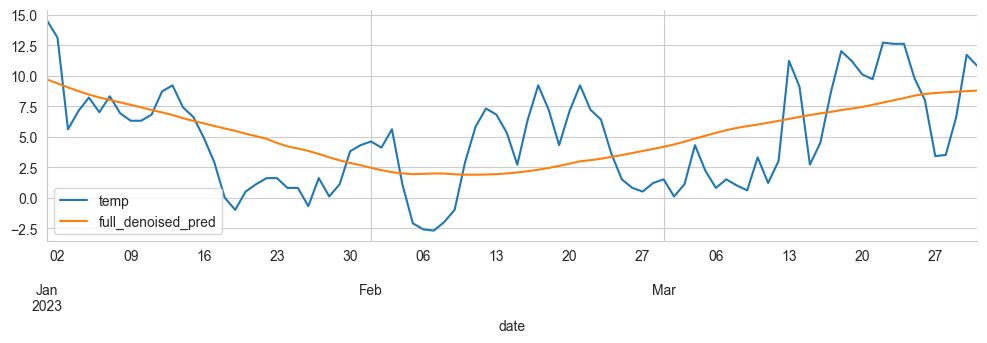

In [327]:
mpl.rc('figure',figsize=(12,3),dpi=100)
test[['temp','full_denoised_pred']].plot(legend=True)
sns.despine()